In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.nn.functional as F
import os
import datetime
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

#empty cuda cache
torch.cuda.empty_cache()

# Models

In [2]:
class ResNetAutoencoder(nn.Module):
    def __init__(self,target_size=501):
        super(ResNetAutoencoder, self).__init__()

        # Load pre-trained ResNet-50
        resnet = models.resnet50(pretrained=True)

        # Remove the fully connected layers
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.target_size = target_size
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)  # Use Sigmoid for normalizing the output to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.adaptive_avg_pool2d(x, (128, self.target_size))  # adapt to your target size
        return x





class FineTuneModel(nn.Module):
    def __init__(self, pretrained_autoencoder, num_classes):
        super(FineTuneModel, self).__init__()
        # Use the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder

        # Adaptive pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head: Three fully connected layers
        self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer
        self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer
        self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes

        # Optionally, add dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Non-linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the encoder
        x = self.encoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Pass through the fully connected layers with ReLU activation and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  
        return x
    

class FineTuneModelFREZ(nn.Module):
    def __init__(self, pretrained_autoencoder, num_classes):
        super(FineTuneModelFREZ, self).__init__()
        # Use the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder

        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Adaptive pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head: Three fully connected layers
        self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer
        self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer
        self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes

        # Optionally, add dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Non-linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the encoder
        x = self.encoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Pass through the fully connected layers with ReLU activation and dropout
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

# Set here the Model that should be fintuned

In [3]:
Pretrain_model_dir = "./results/res_auto"


## Data


In [4]:
#------Datasplit
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)
#train_df, test_df = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=47)
#val_df = test_df
randomstate = 47
train_df, temp = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=randomstate)
test_df, val_df = train_test_split(temp, test_size=0.5, stratify=temp['Label_int'], random_state=randomstate)
# train test split
print("Train size: ", len(train_df))
print("Test size: ", len(test_df))
print("Val size: ", len(val_df))



print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Train size:  3776
Test size:  472
Val size:  472
Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64


In [5]:
# Hyperparameters
num_epochs = config.finetune_epochs 
weight_decay = 0  # L2 regularization
batch_size = config.batch_size
patience = config.patience
# Specify learning rates
learning_rate_encoder = 0.0003
learning_rate_fc = 0.0008
learning_rate = learning_rate_encoder

#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Early stopping parameters
patience = config.patience  # This value can be changed based on how many epochs of no improvement you're willing to wait
early_stop_counter = 0



# Load the entire pre-trained model (from your contrastive training)
#pretrained_model = torch.load(Pretrain_model_dir + '/resNetTry23_11_autoen_model.pth')
pretrained_model = torch.load(Pretrain_model_dir + '/resNet_autoen_model.pth')
encoder_trained = pretrained_model.encoder

data1,_ = next(iter(train_loader))
target_size = data1.shape[3]
print(target_size)



    
# Initialize the FineTuneModel with the pre-trained encoder
model = FineTuneModel(pretrained_model, num_classes).to(device)
#model = FineTuneModelFREZ(pretrained_model, num_classes).to(device)


# Separate parameters of encoder and fully connected layers
encoder_params = model.encoder.parameters()
fc_params = list(model.fc1.parameters()) + list(model.fc2.parameters()) + list(model.fc3.parameters())

# Create parameter groups with different learning rates
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': learning_rate_encoder},
    {'params': fc_params, 'lr': learning_rate_fc}
])


938


In [6]:

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4 ) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) 

#Schedulers
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.6, verbose=True)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=5, mode='triangular')
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)

#new folder path
finetune_results_dir = f'./finetune_results/FT_Autoencoder_ADSMI_{num_epochs}_epochs_{datetime.datetime.now().strftime("%Y-%m-%d-%H")}'

# Create a new folder to save the results
if not os.path.exists(finetune_results_dir):
    os.makedirs(finetune_results_dir)

# create log file
with open(f'{finetune_results_dir}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'Finetuning on AUTOENCODER PRETRAIN{data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'Length of train data in seconds: {config.desired_length_in_seconds}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')


train_losses = []
val_losses = []
best_accuracy = 0
best_loss = 1000
early_stop_counter = 0
#model_path = "./finetune_results/newgpulr0001_checkpoint.pth"

torch.Size([128, 938])
torch.Size([32, 3, 128, 938])


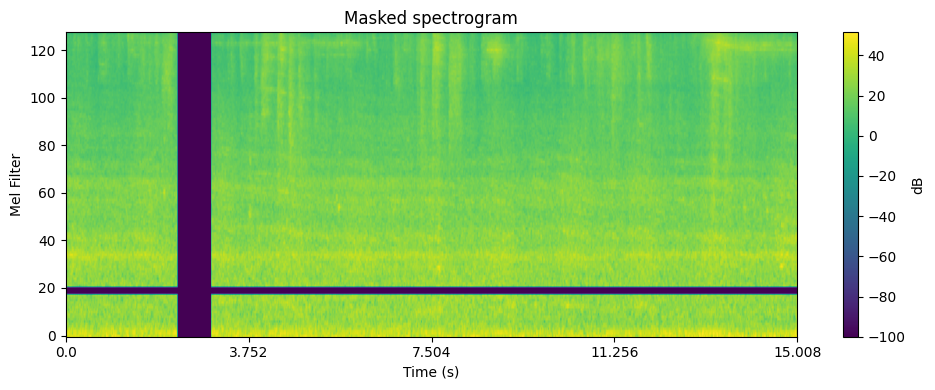

In [7]:
data1,_ = next(iter(train_loader))

def plot_mel_spectrogram(melspe_db, sample_rate, hop_length, name):
    plt.figure(figsize=(10, 4))

    melspe_db_single = melspe_db[0, 0, :, :].squeeze()

    print(melspe_db_single.shape)
    print(melspe_db.shape)

    if melspe_db_single.ndim != 2:
        raise ValueError("melspe_db_single should be a 2D array")

    # Convert tensor data to numpy for visualization
    melspe_db_np = melspe_db_single.cpu().detach().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title(name)

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), 
               np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Call the function with the modified data
plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")


In [8]:
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Temporary list for storing training losses for each batch
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        epoch_train_losses.append(loss.item())  # Append current batch loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Append average loss to main list

    model.eval()
    epoch_val_losses = []  # Temporary list for storing validation losses for each batch
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())  # Append current batch loss

            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate average validation loss for the epoch
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)  # Append average loss to main list

    # Model saving and logging based on accuracy and loss
    accuracy = correct_predictions / total_samples
    if correct_predictions / total_samples > best_accuracy:
        best_accuracy = accuracy
        torch.save(model, finetune_results_dir + '/checkpoint.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
    
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model, finetune_results_dir + '/checkpoint_best_loss.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best loss improved on epoch {epoch}: {best_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    # Logging for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")
    with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy}, Early stopping count: {early_stop_counter} from {patience}\n")

    # Early stopping
    early_stop_counter += 1
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break

100%|██████████| 118/118 [00:28<00:00,  4.19it/s]


Epoch [1/120], Train Loss: 0.8445, Val Loss: 0.6051, Val Accuracy: 74.15%


100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Epoch [2/120], Train Loss: 0.5701, Val Loss: 0.3466, Val Accuracy: 86.44%


100%|██████████| 118/118 [00:27<00:00,  4.31it/s]


Epoch [3/120], Train Loss: 0.3976, Val Loss: 0.3025, Val Accuracy: 88.14%


100%|██████████| 118/118 [00:27<00:00,  4.28it/s]


Epoch [4/120], Train Loss: 0.3549, Val Loss: 0.3044, Val Accuracy: 87.92%


100%|██████████| 118/118 [00:27<00:00,  4.33it/s]


Epoch [5/120], Train Loss: 0.3117, Val Loss: 0.2487, Val Accuracy: 90.04%


100%|██████████| 118/118 [00:26<00:00,  4.39it/s]


Epoch [6/120], Train Loss: 0.2784, Val Loss: 0.2609, Val Accuracy: 89.83%


100%|██████████| 118/118 [00:27<00:00,  4.34it/s]


Epoch [7/120], Train Loss: 0.2709, Val Loss: 0.2415, Val Accuracy: 90.25%


100%|██████████| 118/118 [00:27<00:00,  4.28it/s]


Epoch [8/120], Train Loss: 0.2377, Val Loss: 0.2936, Val Accuracy: 89.41%


100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Epoch [9/120], Train Loss: 0.2258, Val Loss: 0.2142, Val Accuracy: 91.74%


100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Epoch [10/120], Train Loss: 0.2175, Val Loss: 0.2210, Val Accuracy: 91.95%


100%|██████████| 118/118 [00:27<00:00,  4.27it/s]


Epoch [11/120], Train Loss: 0.2354, Val Loss: 0.2380, Val Accuracy: 88.98%


100%|██████████| 118/118 [00:27<00:00,  4.30it/s]


Epoch [12/120], Train Loss: 0.2066, Val Loss: 0.2292, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:27<00:00,  4.25it/s]


Epoch [13/120], Train Loss: 0.1907, Val Loss: 0.2520, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Epoch [14/120], Train Loss: 0.1750, Val Loss: 0.2017, Val Accuracy: 92.37%


100%|██████████| 118/118 [00:27<00:00,  4.25it/s]


Epoch [15/120], Train Loss: 0.1669, Val Loss: 0.2066, Val Accuracy: 91.53%


100%|██████████| 118/118 [00:27<00:00,  4.25it/s]


Epoch [16/120], Train Loss: 0.1601, Val Loss: 0.2685, Val Accuracy: 89.83%


100%|██████████| 118/118 [00:27<00:00,  4.25it/s]


Epoch [17/120], Train Loss: 0.1632, Val Loss: 0.2132, Val Accuracy: 93.22%


100%|██████████| 118/118 [00:27<00:00,  4.24it/s]


Epoch [18/120], Train Loss: 0.1443, Val Loss: 0.2527, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:27<00:00,  4.24it/s]


Epoch [19/120], Train Loss: 0.1694, Val Loss: 0.2746, Val Accuracy: 91.95%


100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Epoch [20/120], Train Loss: 0.1478, Val Loss: 0.2747, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Epoch 00021: reducing learning rate of group 0 to 1.8000e-04.
Epoch [21/120], Train Loss: 0.1164, Val Loss: 0.2626, Val Accuracy: 91.53%


100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


Epoch [22/120], Train Loss: 0.1161, Val Loss: 0.3427, Val Accuracy: 90.04%


100%|██████████| 118/118 [00:27<00:00,  4.31it/s]


Epoch [23/120], Train Loss: 0.1116, Val Loss: 0.2834, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Epoch [24/120], Train Loss: 0.0907, Val Loss: 0.2874, Val Accuracy: 89.62%


100%|██████████| 118/118 [00:27<00:00,  4.27it/s]


Epoch [25/120], Train Loss: 0.0832, Val Loss: 0.3445, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:27<00:00,  4.27it/s]


Epoch [26/120], Train Loss: 0.0785, Val Loss: 0.3039, Val Accuracy: 90.68%


100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Epoch [27/120], Train Loss: 0.0905, Val Loss: 0.3084, Val Accuracy: 89.41%


100%|██████████| 118/118 [00:27<00:00,  4.22it/s]


Epoch 00028: reducing learning rate of group 0 to 1.0800e-04.
Epoch [28/120], Train Loss: 0.0798, Val Loss: 0.3072, Val Accuracy: 88.98%


100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Epoch [29/120], Train Loss: 0.0691, Val Loss: 0.3268, Val Accuracy: 90.04%


100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Epoch [30/120], Train Loss: 0.0698, Val Loss: 0.3765, Val Accuracy: 88.14%


100%|██████████| 118/118 [00:27<00:00,  4.25it/s]


Epoch [31/120], Train Loss: 0.0688, Val Loss: 0.4259, Val Accuracy: 89.41%
Early stopping on epoch 31


In [9]:
# Save full model
torch.save(model, finetune_results_dir + '/Full_model_checkpoint.pth')

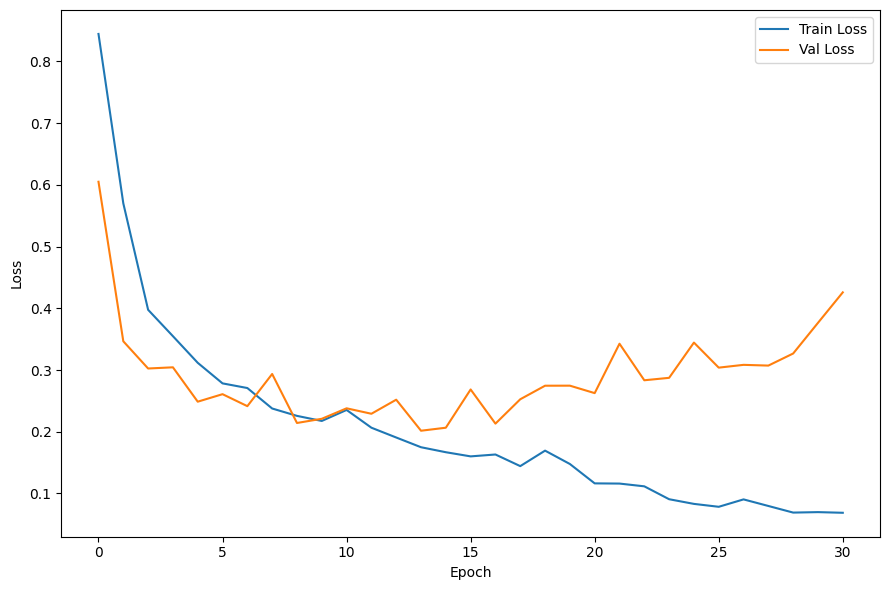

<Figure size 640x480 with 0 Axes>

In [10]:
# Convert tensors in the lists to numbers if necessary
train_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# Now plot these lists
plt.figure(figsize=(9, 6))
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(val_losses_cpu, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig(f'{finetune_results_dir}/loss_plot.png')

20

Evaluation Results:
Balanced Accuracy2: 85.31%
Test Accuracy: 90.04%

Evaluation Results:
Accuracy: 90.04%
Precision: 90.17%
Recall: 90.04%
F1-score: 90.04%
Kappa: 84.24%
                         precision    recall  f1-score   support

            [Kreischen]       0.89      0.94      0.91       220
[Kreischen][Quietschen]       0.88      0.89      0.88        71
              [Negativ]       0.94      0.87      0.91       167
           [Quietschen]       0.71      0.71      0.71        14

               accuracy                           0.90       472
              macro avg       0.86      0.85      0.85       472
           weighted avg       0.90      0.90      0.90       472



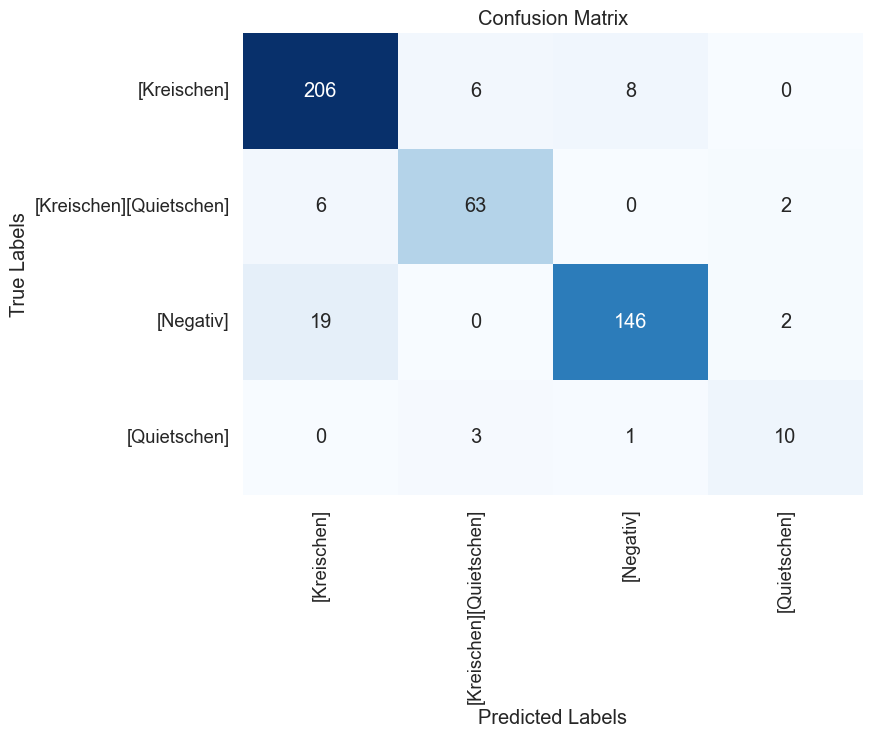

In [11]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score

print(config.val_sound_length)

# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#config.val_sound_length = 20

# Create a data loader for the test set
#_,val_loader = DL.create_generators_finetune_train(train_df,val_df)  
val_loader = DL.create_generators_finetune_val(val_df)


model = torch.load(finetune_results_dir + '/Full_model_checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation 
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

#create classification results text file
with open(f'{finetune_results_dir}/results_file_full.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Random State:{randomstate} \n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

#save this plot as a png file
print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{finetune_results_dir}/confusion_matrix_full.png')









Evaluating: 100%|██████████| 472/472 [00:03<00:00, 123.46batch/s]



Evaluation Results:
Balanced Accuracy2: 91.34%
Test Accuracy: 91.74%

Evaluation Results:
Accuracy: 91.74%
Precision: 91.89%
Recall: 91.74%
F1-score: 91.74%
Kappa: 86.92%
                         precision    recall  f1-score   support

            [Kreischen]       0.90      0.95      0.92       220
[Kreischen][Quietschen]       0.93      0.89      0.91        71
              [Negativ]       0.95      0.89      0.92       167
           [Quietschen]       0.81      0.93      0.87        14

               accuracy                           0.92       472
              macro avg       0.90      0.91      0.90       472
           weighted avg       0.92      0.92      0.92       472



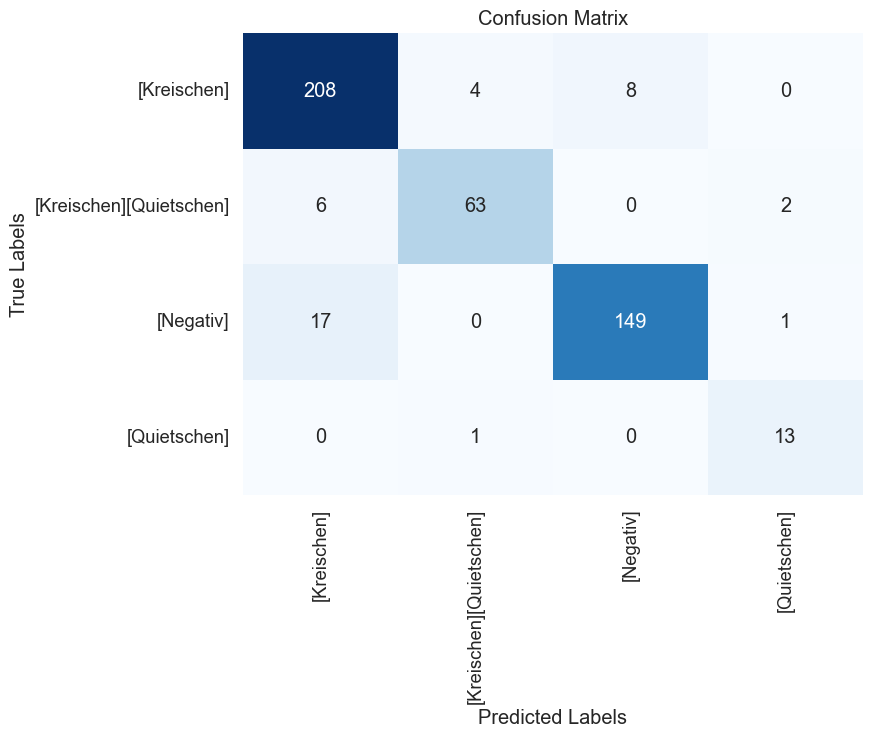

In [12]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score



# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#config.val_sound_length = 20

# Create a data loader for the test set
#_,val_loader = DL.create_generators_finetune_train(train_df,val_df)  
val_loader = DL.create_generators_finetune_val(val_df)


model = torch.load(finetune_results_dir + '/checkpoint.pth')
#model = torch.load('./finetune_results/FT_ADSMI_120_epochs_2023-11-11-15/checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation 
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []


with torch.no_grad():
    # Wrap the DataLoader with tqdm for a progress bar
    for spectrograms, labels in tqdm(val_loader, desc="Evaluating", unit="batch"):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)

        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())


# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

#create classification results text file
with open(f'{finetune_results_dir}/results_file_best.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Random State:{randomstate} \n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plot_confusion_matrix(conf_mat, true_labels_dic.values()) as a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{finetune_results_dir}/confusion_matrix_best.png')










Evaluation Results:
Balanced Accuracy2: 86.36%
Test Accuracy: 92.16%

Evaluation Results:
Accuracy: 92.16%
Precision: 92.39%
Recall: 92.16%
F1-score: 92.03%
Kappa: 87.43%
                         precision    recall  f1-score   support

            [Kreischen]       0.90      0.97      0.93       220
[Kreischen][Quietschen]       0.96      0.76      0.85        71
              [Negativ]       0.95      0.94      0.95       167
           [Quietschen]       0.79      0.79      0.79        14

               accuracy                           0.92       472
              macro avg       0.90      0.86      0.88       472
           weighted avg       0.92      0.92      0.92       472



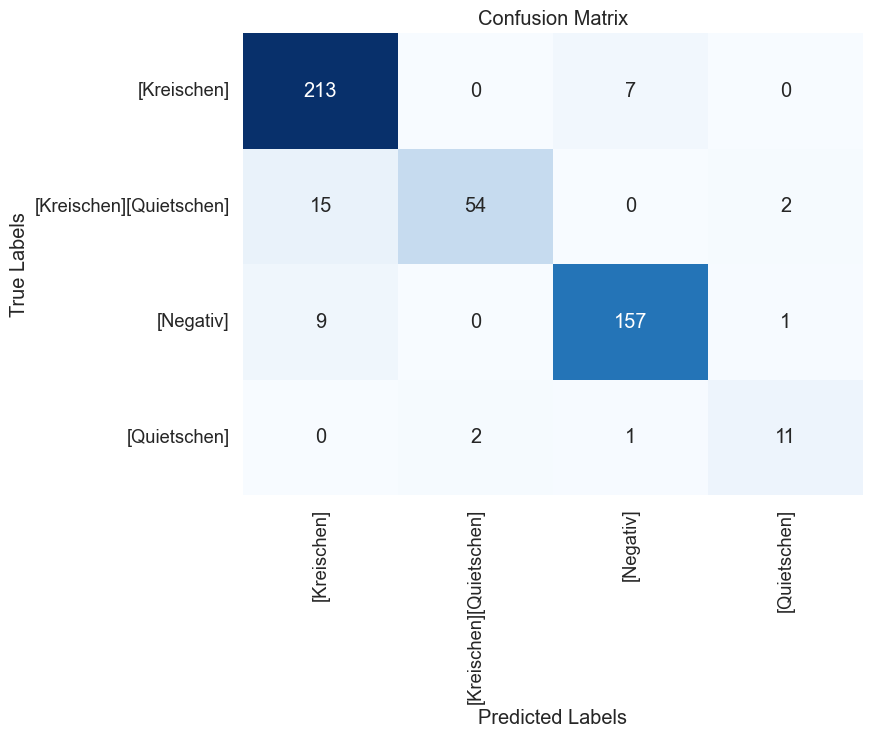

In [13]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score



# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#config.val_sound_length = 20

# Create a data loader for the test set
# Create a data loader for the test set
#_,val_loader = DL.create_generators_finetune_train(train_df,val_df)  
val_loader = DL.create_generators_finetune_val(val_df)

model = torch.load(finetune_results_dir + '/checkpoint_best_loss.pth')
#model = torch.load('./finetune_results/FT_ADSMI_120_epochs_2023-11-11-15/checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation 
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

#create classification results text file
with open(f'{finetune_results_dir}/results_file_best_loss.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Random State:{randomstate} \n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plot_confusion_matrix(conf_mat, true_labels_dic.values()) as a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{finetune_results_dir}/confusion_matrix_best_loss.png')









tensor([[[[ 50.5588,  46.9874,  37.5173,  ...,  29.3517,  35.0672,  35.1870],
          [ 41.6866,  39.6989,  43.0171,  ...,  36.5440,  33.3580,  35.0331],
          [ 40.1612,  41.8726,  43.2752,  ...,  39.5313,  38.0732,  34.7872],
          ...,
          [ 28.3739,  28.2194,  28.8769,  ...,   0.2529,   1.1334,   2.1001],
          [ 25.4613,  25.4607,  26.1636,  ...,  -7.3438,  -7.2985,  -5.3742],
          [ 23.1602,  21.4659,  22.1881,  ..., -10.8985, -10.0693,  -8.1593]],

         [[ 50.5588,  46.9874,  37.5173,  ...,  29.3517,  35.0672,  35.1870],
          [ 41.6866,  39.6989,  43.0171,  ...,  36.5440,  33.3580,  35.0331],
          [ 40.1612,  41.8726,  43.2752,  ...,  39.5313,  38.0732,  34.7872],
          ...,
          [ 28.3739,  28.2194,  28.8769,  ...,   0.2529,   1.1334,   2.1001],
          [ 25.4613,  25.4607,  26.1636,  ...,  -7.3438,  -7.2985,  -5.3742],
          [ 23.1602,  21.4659,  22.1881,  ..., -10.8985, -10.0693,  -8.1593]],

         [[ 50.5588,  46.9874,

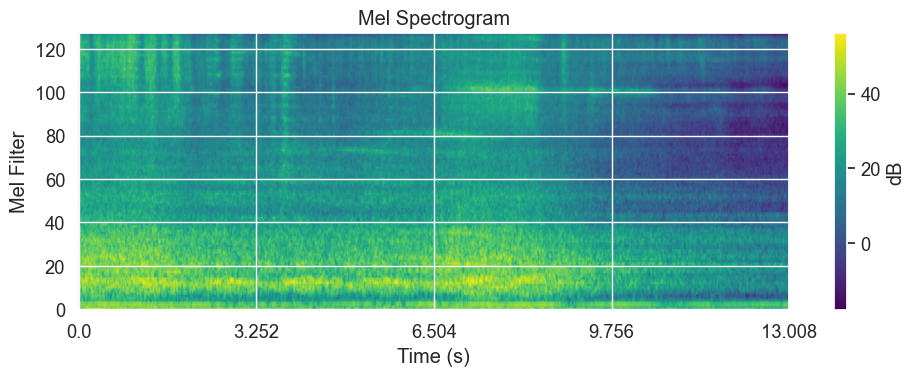

In [14]:
#print first batch from val_loader
iterator = iter(val_loader)
batch = next(iterator)
spectrograms, labels = batch


print(spectrograms)
#plot spectrograms
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
def plot_mel_spectrogram(melspe_db, sample_rate, hop_length):
    plt.figure(figsize=(10, 4))

    # Assuming melspe_db is a 4D tensor and we only want to plot the first channel of the first sample
    melspe_db_np = melspe_db[0, 0].cpu().detach().numpy()  # Selecting the first channel

    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title('Mel Spectrogram')

    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

#plot spectrograms

plot_mel_spectrogram(spectrograms, 32000, 512)